In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np

In [37]:
base_dir = "/content/drive/MyDrive/DeepProfiler/DeepProfiler-docs/Experimental_results/"
folder = "BBBC022"
path = f"{base_dir}{folder}/Classification_reports/"
dataset = "bbbc022"
partition_dir = "Cells_out"
layer = "conv6a"
epoch = "e30"
#levels = ["image_level", "well_level", "treatment_level"]
levels = ["well_level", "treatment_level"]

In [4]:
configs = {
    "BBBC037":{
        "AKA":"TAORF",
        "trt_cols":["broad_sample", "pert_name"],
        "moa_cols":["broad_sample", "pert_name"],
        "moa_field":"Metadata_moa",
        "sphering":{
            "Indiv_dataset": "1e-4",
            "CellProfiler":"1e-4",
            "Combined_set": "1e-5",
            "Pretrained": "1e-4"
            }
    },
    "BBBC022":{
        "AKA":"BBBC022",
        "trt_cols":["Compound"],
        "moa_cols":["Var1"],
        "moa_field":"Metadata_moa.x",
        "sphering":{
            "Indiv_dataset": "1e-3",
            "CellProfiler":"1e-1",
            "Combined_set": "1e-3",
            "Pretrained": "1e-3"
            }
    },
    "BBBC036":{
        "AKA":"BBBC036",
        "trt_cols":["Compound"],
        "moa_cols":["Var1"],
        "moa_field":"Metadata_moa.x",
        "sphering":{
            "Indiv_dataset": "1e-3",
            "CellProfiler":"1e-3",
            "Combined_set": "1e-3",
            "Pretrained": "1e-3"
            }
    }
}

In [5]:
def stats_at_level(name_base, level):
  fh = pd.read_csv(f"{name_base}_{level}.csv", index_col=0)
  result = {"Approach":approach, "Level":level, "Hits_1_pct": np.sum(fh["top_percent"] <= 1)}
  return result

In [6]:
def stats_at_moa(name_base, trt_index):
  fh = pd.read_csv(f"{name_base}_treatment_level.csv", index_col=0)
  moa_level = pd.merge(fh, trt_index, left_on=configs[folder]["trt_cols"], right_on=configs[folder]["moa_cols"])
  stats = moa_level.groupby(configs[folder]["moa_field"]).mean().reset_index().sort_values("first_hit").mean()
  result = {"Approach":approach, "Level":"treatment_level", "FirstHitPos": stats.first_hit, "MedianTopPercent": stats.top_percent}
  return result

In [7]:
def compute_stats(name_base, results, moa_stats, image_level=True):
  for level in levels:
    if level == "image_level" and not image_level: continue
    r = stats_at_level(name_base, level)
    results.append(r)
  moa_stats.append(stats_at_moa(name_base, trt_index))

In [38]:
trt_index = pd.read_csv(f"{base_dir}{folder}/{configs[folder]['AKA']}_MOA_MATCHES_official.csv")

In [39]:
results = []
moa_stats = []

In [40]:
approach = "Indiv_dataset"
regparam = configs[folder]["sphering"][approach]
partition_name = "cellsout"
name_base = f"{base_dir}{folder}/First_hit/{approach}/{partition_dir}/{layer}/efn128_{partition_name}_{layer}_{regparam}_{epoch}"
compute_stats(name_base, results, moa_stats)

#downstream = pd.read_csv(f"{base_dir}{folder}/mAP_FoE/{approach}/{partition_dir}/{layer}/efn128_{partition_name}_{layer}_{regparam}_{epoch}.csv", index_col=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [41]:
approach = "Combined_set"
regparam = configs[folder]["sphering"][approach]
partition_name = "combinedcellsout"
name_base = f"{base_dir}{folder}/First_hit/{approach}/{partition_dir}/efn128_{partition_name}_{layer}_{regparam}_{epoch}"
compute_stats(name_base, results, moa_stats)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [42]:
approach = "CellProfiler"
regparam = configs[folder]["sphering"][approach]
partition_name = "cellprofiler"
name_base = f"{base_dir}{folder}/First_hit/{approach}/{partition_name}_{regparam}"
compute_stats(name_base, results, moa_stats, image_level=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [43]:
approach = "Pretrained"
regparam = configs[folder]["sphering"][approach]
partition_name = "pretrained"
name_base = f"{base_dir}{folder}/First_hit/{approach}/{layer}/efn128_{partition_name}_{layer}_{regparam}"
compute_stats(name_base, results, moa_stats)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


In [44]:
results = pd.DataFrame(data=results)
results = results[results.Level != "image_level"]
results

,Approach,Level,Hits_1_pct
0,Indiv_dataset,well_level,470
1,Indiv_dataset,treatment_level,256
2,Combined_set,well_level,339
3,Combined_set,treatment_level,277
4,CellProfiler,well_level,268
5,CellProfiler,treatment_level,263
6,Pretrained,well_level,330
7,Pretrained,treatment_level,255


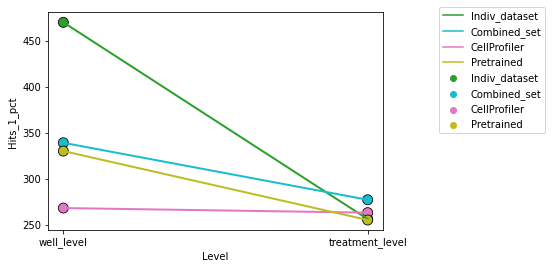

In [45]:
#fig, ax = plt.subplots(figsize=(8,6))
main_colors = ["tab:green","tab:cyan", "tab:pink","tab:olive"]
sb.lineplot(data=results, x="Level", y="Hits_1_pct", hue="Approach", palette=main_colors, linewidth = 2)
g = sb.scatterplot(data=results, x="Level", y="Hits_1_pct", hue="Approach", palette=main_colors, s=100, edgecolor="black")
g.legend(bbox_to_anchor=(1.5, 1.05))
#g.get_legend().remove()

In [18]:
results["Well-level"] = 0
results["Treatment-level"] = 0
results.loc[results.Level == "well_level", "Well-level"] = results.loc[results.Level == "well_level", "Hits_1_pct"]
results.loc[results.Level == "treatment_level", "Treatment-level"] = results.loc[results.Level == "treatment_level", "Hits_1_pct"]

In [19]:
R = results.groupby("Approach").sum().reset_index()

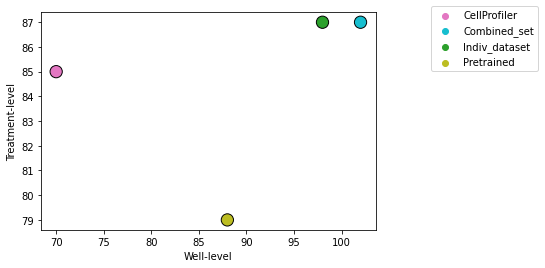

In [20]:
main_colors = ["tab:pink","tab:cyan", "tab:green","tab:olive"]
g = sb.scatterplot(data=R, x="Well-level", y="Treatment-level", hue="Approach", palette=main_colors, s=150, edgecolor="black")
g.legend(bbox_to_anchor=(1.5, 1.05))

In [21]:
M = pd.merge(pd.DataFrame(data=moa_stats), R, on="Approach")

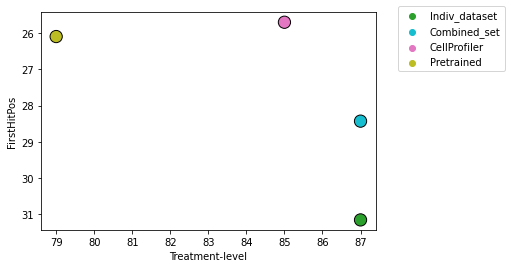

In [22]:
main_colors = ["tab:green","tab:cyan","tab:pink", "tab:olive"]
g = sb.scatterplot(data=M, x="Treatment-level", y="FirstHitPos", hue="Approach", palette=main_colors, s=150, edgecolor="black")
g.invert_yaxis()
g.legend(bbox_to_anchor=(1.4, 1.05))